<a href="https://colab.research.google.com/github/rounit57/Deep_learning-/blob/main/Final_Q1_Q10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb
# !wandb login
import wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.datasets import fashion_mnist
import numpy as np
from  matplotlib import pyplot as plt
import time
import math
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
imagedata=fashion_mnist.load_data()
(X,Y), (X_test,Y_test)=imagedata
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.1,random_state = 43)

no_of_class = len(np.unique(Y))
pix_size = X.shape[1]*X.shape[2]

global no_of_class
global pix_size

X_train = (X_train.reshape(X_train.shape[0],pix_size,1))/255.0
X_val = (X_val.reshape(X_val.shape[0],pix_size,1))/255.0
X_test = (X_test.reshape(X_test.shape[0],pix_size,1))/255.0

# Y_train = one_hot_encode_encode(Y_train).T
# Y_val = onr_hot_encode(Y_val).T
# Y_test = one_hot_encode_encode(Y_test).T



# print(X_train.shape) 
# print(X_test.shape)
# print(X_val.shape)
# print(Y_train.shape)
# print(Y_test.shape)


In [ ]:
wandb.init(project="cs6910_Ass_01_Q1", entity="rounit57")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


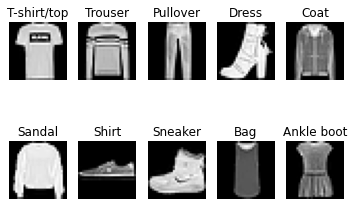

In [ ]:
label= {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot' }

rows = 2
columns = 5
no_class = 10
y=list(Y_train)
for i in range(no_class):
     
    sample=y.index(i)
    image = X[sample]
    plt.subplot(rows, columns,i+1)
    wandb.log({"Fashion_mnist": [wandb.Image(image,caption=label[i])]})
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(label[i])
wandb.log({"image": plt})

Activation Functions and thei derivatives

In [ ]:
def sigmoid(z,derivative = False):
  if derivative:
    return sigmoid_diff(z)
  return 1/(1+(np.exp(-z)))
  


def softmax(z,derivative = False):
  if derivative:
    return softmax_diff(z)
  return np.exp(z) / np.sum(np.exp(z))


def relu(z,derivative = False):
  if derivative:
    return relu_diff(z) 
  return np.maximum(0,z)

        
def tanh_fun(z,derivative = False):
  if derivative:
    return tanh_fun_diff(z)
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z)) 


def sigmoid_diff(z):
  sig = 1 / (1 + np.exp(-z))
  return sig*(1-sig)

def softmax_diff(z):    
  return z*(1-z)

def relu_diff(z):
  relu = np.maximum(0, z)
  relu[relu > 0] = 1
  return relu

def tanh_fun_diff(z):
  tanh=(np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
  return 1-tanh**2


# Choosing activation function
def activation(act):
  if act=='sigmoid':
    return sigmoid
  if act=='tanh':
    return tanh_fun
  if act=='ReLU':
    return relu



One HOt Encoding

In [ ]:
def one_hot_encode(y, num_output_nodes):
  n = np.zeros((num_output_nodes, len(y)))
  for i,j in enumerate(y):
    n[j,i] = 1
  return n

Weight Initialization

In [ ]:
def para_init(N_I_nodes, H_layer, N_O_nodes, init_type):
  W = []
  B = []
  if init_type == "random":
    W.append(np.random.randn(H_layer[0],N_I_nodes)*0.1)
    B.append(np.random.randn(H_layer[0], 1)*0.1)
    for i in range(len(H_layer)-1):
      W.append(np.random.randn(H_layer[i+1],H_layer[i])*0.1)
      B.append(np.random.randn(H_layer[i+1], 1)*0.1)
    W.append(np.random.randn(N_O_nodes, H_layer[-1])*0.1)
    B.append(np.random.randn(N_O_nodes, 1)*0.1)
    return W, B

  if init_type == "xavier":
    W.append(np.random.randn(H_layer[0],N_I_nodes)*np.sqrt(2/(H_layer[0] + N_I_nodes)))
    B.append(np.random.randn(H_layer[0], 1)*0.1)
    for i in range(len(H_layer)-1):
      W.append(np.random.randn(H_layer[i+1],H_layer[i])*np.sqrt(2/(H_layer[i+1] + H_layer[i])))
      B.append(np.random.randn(H_layer[i+1], 1)*0.1)
    W.append(np.random.randn(N_O_nodes, H_layer[-1])*np.sqrt(2/(N_O_nodes + H_layer[-1])))
    B.append(np.random.randn(N_O_nodes, 1)*0.1)
    return W, B

Forward Propogation

In [ ]:
def feed_forward(x, W, B, act_T):
  h = []
  a = []
  sigma = activation(act_T) 
  h.append(x)  
  a.append(np.dot(W[0], h[0]) + B[0])
  for i in range(len(W)-1):
    h.append(sigma(a[-1]))
    a.append(np.dot(W[i+1], h[-1]) + B[i+1])
  Y_bar = softmax(a[-1])

  return Y_bar, h, a

Compute Loss And Accuracy

In [ ]:
def Loss(y,Y_bar, loss_T, W, reg_lamda):
  if loss_T == "squared_error":
    error = np.sum((one_hot_encode(y, 10)-Y_bar)**2)/(2*one_hot_encode(y, 10).shape[1])
  if loss_T == "cross_entropy":
    error = -1*np.sum(np.multiply(one_hot_encode(y, 10),np.log(Y_bar)))/one_hot_encode(y, 10).shape[1]         # hardcoded classes = 10

  if W:
    r = 0
    for i in range(len(W)):
      r += np.sum((np.array(W, dtype = object) **2)[i])
    error = error + reg_lamda * r

  return error


def accuracy(Y_bar, true_Y):
  return np.mean(np.argmax(Y_bar, axis = 0) ==true_Y )*100

Backward Propogation

In [ ]:
def back_prop(x, y, Y_bar, a, h , W, B, batch_size, loss_T, act_T):
  grad_h = [0]*len(h)
  grad_a = [0]*len(a)
  grad_w = [0]*len(W)
  grad_b = [0]*len(B)

  sigma = activation(act_T) 

  if loss_T == "cross_entropy":
    grad_h[-1] = -1*(y/Y_bar)
    grad_a[-1] = -1*(y-Y_bar)
  if loss_T == "squared_error":   
    grad_h[-1] = Y_bar - y
    grad_a[-1] = (Y_bar - y)*softmax(a[-1])*(1-softmax(a[-1]))

  for i in range(len(W)-1, -1, -1):
    grad_w[i] = np.dot(grad_a[i], h[i].T)
    grad_b[i] = np.dot(grad_a[i], np.ones((batch_size,1)))
    if i > 0:
      grad_h[i-1] = np.dot(W[i].T, grad_a[i])
      grad_a[i-1]  = np.multiply(grad_h[i-1],sigma(a[i-1], derivative = True))

  return grad_w, grad_b, grad_h, grad_a

Optmizers : 
SGD , MOMENTUM-BASED-GD , RMSPROP , NESTEROV , ADAM

In [ ]:
class SGD:
  #  Stochastic Gradient Descent
  def __init__(self, lr = 0.001, reg = 0):
    self.lr = lr
    self.reg = reg
  
  def update(self, w,b, grad_w, grad_b):
    W = np.array(w, dtype = object)
    B = np.array(b, dtype = object)

    W = (1-self.lr*self.reg)*W - self.lr * np.array(grad_w, dtype = object)
    B = (1-self.lr*self.reg)*B - self.lr * np.array(grad_b, dtype = object)

    return W.tolist(),B.tolist()


class Momentum_GD:

  def __init__(self, lr = 0.001, gamma = 0.9, reg = 0):
    self.lr = lr
    self.gamma = gamma
    self.Wmoments = None
    self.Bmoments = None
    self.reg = reg


  def update(self, w,b, grad_w, grad_b):
    para = {'w':w, 'b':b}

    if self.Wmoments == None:
      self.Wmoments = [0] * len(para['w'])
      for i in range(len(para['w'])):
        self.Wmoments[i] = np.zeros_like(para['w'][i])

    if self.Bmoments == None:
      self.Bmoments = [0] * len(para['b'])
      for i in range(len(para['b'])):
        self.Bmoments[i] = np.zeros_like(para['b'][i])
    
    self.Wmoments = self.gamma * np.array(self.Wmoments, dtype = object) + self.lr * np.array(grad_w, dtype = object)
    W = (1-self.lr*self.reg)*np.array(para['w'], dtype = object) - self.Wmoments
    self.Wmoments = self.Wmoments.tolist()

    self.Bmoments = self.gamma * np.array(self.Bmoments, dtype = object) + self.lr * np.array(grad_b, dtype = object)
    B = (1-self.lr*self.reg)*np.array(para['b'], dtype = object) - self.Bmoments
    self.Bmoments = self.Bmoments.tolist()
    
    return W.tolist(), B.tolist()


class RMSprop:
  def __init__(self, lr=0.01, BT = 0.99):
    
    self.lr = lr
    self.vW = None
    self.vB = None
    self.BT = BT

  def update(self, w,b, grad_w, grad_b):
    para = {'w':w, 'b':b}
    if self.vW == None:
      self.vW = [0] * len(para['w'])
      for i in range(len(para['w'])):
        self.vW[i] = np.zeros_like(para['w'][i])

    if self.vB == None:
      self.vB = [0] * len(para['b'])
      for i in range(len(para['b'])):
        self.vB[i] = np.zeros_like(para['b'][i])

    self.vW = self.BT*np.array(self.vW, dtype = object) + (1-self.BT)*(np.array(grad_w, dtype = object) **2) 
    W = (1-self.lr*self.reg)*np.array(para['w'], dtype = object) - (self.lr/((self.vW + 1e-7)**0.5)) * np.array(grad_w, dtype = object)
    self.vW = self.vW.tolist()

    self.vB = self.BT*np.array(self.vB, dtype = object) + (1-self.BT)*(np.array(grad_b, dtype = object) **2 )
    B = (1-self.lr*self.reg)*np.array(para['b'], dtype = object) - (self.lr/((self.vB + 1e-7)**0.5)) * np.array(grad_b, dtype = object)
    self.vB = self.vB.tolist()

    return W.tolist(), B.tolist()

class Nesterov:   
  def __init__(self, lr=0.01, gamma=0.9):
    self.lr = lr
    self.reg = None
    self.gamma = gamma                                                             
    self.Wmoments = None
    self.Bmoments = None
    self.act_T = None
    self.loss_T = None
        
  def update(self, w,b, grad_w, grad_b):
    para = {'w':w, 'b':b}
    if self.Wmoments == None:
      self.Wmoments = [0] * len(para['w'])
      for i in range(len(para['w'])):
        self.Wmoments[i] = np.zeros_like(para['w'][i])

    if self.Bmoments == None:
      self.Bmoments = [0] * len(para['b'])
      for i in range(len(para['b'])):
        self.Bmoments[i] = np.zeros_like(para['b'][i])


    W_look_ahead = np.array(para['w'], dtype = object) - self.gamma*np.array(self.Wmoments, dtype = object)
    B_look_ahead = np.array(para['b'], dtype = object) - self.gamma*np.array(self.Bmoments, dtype = object)
    
    out, temp_h, temp_a = feed_forward(x,W_look_ahead.tolist(),B_look_ahead.tolist(), self.act_T)
    grad_w_look_ahead, grad_b_look_ahead, _, _ = back_prop(x, y,out,temp_a,temp_h, W_look_ahead.tolist(),B_look_ahead.tolist(), x.shape[1], self.loss_T, self.act_T)

    
    self.Wmoments = self.gamma*np.array(self.Wmoments, dtype = object) + self.lr * np.array(grad_w_look_ahead, dtype = object)
    self.Bmoments = self.gamma*np.array(self.Bmoments, dtype = object) + self.lr * np.array(grad_b_look_ahead, dtype = object)

    W = (1-self.lr*self.reg)*np.array(para['w'], dtype = object) - self.Wmoments
    self.Wmoments = self.Wmoments.tolist()

    B = (1-self.lr*self.reg)*np.array(para['b'], dtype = object) - self.Bmoments
    self.Bmoments = self.Bmoments.tolist()

    return W.tolist(), B.tolist()

class Adam:
  def __init__(self, lr=0.001, BT1=0.9, BT2=0.999, reg = 0):
    self.lr = lr
    self.BT1 = BT1
    self.BT2 = BT2
    self.t = 0
    self.mW = None
    self.vW = None
    self.mB = None
    self.vB = None
    self.reg = None
        
  def update(self, w,b, grad_w, grad_b):
    para = {'w':w, 'b':b}

    if self.mW is None:
      self.mW, self.vW = [0] * len(para['w']), [0] * len(para['w'])
      for i in range(len(para['w'])):
        self.mW[i] = np.zeros_like(para['w'][i])
        self.vW[i] = np.zeros_like(para['w'][i])

    if self.mB is None:
      self.mB, self.vB = [0] * len(para['b']), [0] * len(para['b'])
      for i in range(len(para['b'])):
        self.mB[i] = np.zeros_like(para['b'][i])
        self.vB[i] = np.zeros_like(para['b'][i])
    

    self.t += 1
    self.mW = (self.BT1 * np.array(self.mW, dtype = object)) + (1-self.BT1)*(np.array(grad_w, dtype = object))
    self.vW = (self.BT2 * np.array(self.vW, dtype = object)) + (1-self.BT2)*((np.array(grad_w, dtype = object)**2))

    self.mB = (self.BT1 * np.array(self.mB, dtype = object)) + (1-self.BT1)*(np.array(grad_b, dtype = object))
    self.vB = (self.BT2 * np.array(self.vB, dtype = object)) + (1-self.BT2)*((np.array(grad_b, dtype = object)**2))

    # Bias Correction
    self.mW = (self.mW)*(1.0/(1-(self.BT1**self.t)))
    self.vW = (self.vW)*(1.0/(1-(self.BT2**self.t)))
    self.mB = (self.mB)*(1.0/(1-(self.BT1**self.t)))
    self.vB = (self.vB)*(1.0/(1-(self.BT2**self.t)))

    W = (1-self.lr*self.reg)*np.array(para['w'], dtype = object) - (self.lr/((self.vW + 1e-7)**0.5)) * self.mW
    self.vW = self.vW.tolist()
    self.mW = self.mW.tolist()

    B = (1-self.lr*self.reg)*np.array(para['b'], dtype = object) - (self.lr/((self.vB + 1e-7)**0.5)) * self.mB
    self.vB = self.vB.tolist()
    self.mB = self.mB.tolist()

    return W.tolist(), B.tolist() 

Training Model

In [ ]:
def train(X_train, Y_train,x_val, y_val, N_I_nodes, H_layer, N_O_nodes, init_type, epochs, batch_size, loss_T,act_T, optimizer_name, learning_rate, reg_lamda):
  if optimizer_name=='sgd':
    optimizer = SGD()
  elif optimizer_name=='momentum':
    optimizer = Momentum_GD()
  elif optimizer_name=='rmsprop':
    optimizer = RMSprop()
  elif optimizer_name=='nesterov':
    optimizer = Nesterov()
  elif optimizer_name=='adam':
    optimizer = Adam()    
  

  try:   
    optimizer.act_T = act_T
    optimizer.loss_T = loss_T
  except:
    pass

  W, B = para_init(N_I_nodes,H_layer, N_O_nodes, init_type)
  N = X_train.shape[0]
  n_batches = int(np.floor(N/batch_size))
  optimizer.lr = learning_rate
  optimizer.reg = reg_lamda

  for epoch in range(epochs):

    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    l = 0
    acc = 0
    temp = 0
    for batch in range(n_batches):
      x = np.squeeze(X_train[batch*batch_size:batch_size+batch*batch_size]).T
      y = one_hot_encode(Y_train[batch*batch_size:batch_size+batch*batch_size], 10)
      Y_bar, h, a = feed_forward(x, W,B, act_T)
      grad_w, grad_b, grad_h, grad_a = back_prop(x, y,Y_bar,a,h, W,B, batch_size, loss_T, act_T)
      W,B = optimizer.update(W,B, grad_w,grad_b)
      l += Loss(Y_train[batch*batch_size:batch_size+batch*batch_size],Y_bar, loss_T, W,reg_lamda)
      acc += accuracy(Y_bar, Y_train[batch*batch_size:batch_size+batch*batch_size])

    if N%batch_size != 0:
        x = np.squeeze(X_train[-1*(N%batch_size):]).T
        y = one_hot_encode(Y_train[-1*(N%batch_size):], 10)
        Y_bar, h, a = feed_forward(x, W,B, act_T)
        grad_w, grad_b, grad_h, grad_a = back_prop(x, y,Y_bar,a,h, W,B, N%batch_size, loss_T, act_T)
        W,B = optimizer.update(W,B, grad_w,grad_b)
        l += Loss(Y_train[-1*(N%batch_size):],Y_bar, loss_T, W,reg_lamda)
        acc += accuracy(Y_bar, Y_train[-1*(N%batch_size):])
        temp = 1

    l = l/(n_batches + (N%batch_size))
    acc = acc/(n_batches + temp)

    train_loss.append(l)
    train_accuracy.append(acc)
    #print(f"Epoch:{epoch+1}")
    #print(f"Train Loss: {l}")
    #print(f"Train Accuracy: {acc}")

    # Validation
    if x_val.any():
      y_val_hat, _,_ = feed_forward(np.squeeze(x_val).T, W,B, act_T)
      val_acc = accuracy(y_val_hat,y_val)
      val_l = Loss(y_val, y_val_hat, loss_T,W = None, reg_lamda = reg_lamda)
      val_accuracy.append(val_acc)
      val_loss.append(val_l)
      #print(f"Val Loss: {val_l}")
      #print(f"Val Accuracy: {val_acc}")

    wandb.log({"epoch":epoch,"Train_loss":l,"Train_acc":acc,"val_loss":val_l,"val_Accuracy":val_acc})
  return W,B, train_loss, train_accuracy, val_loss, val_accuracy

Sweep configuration for Cross Entropy

In [ ]:
sweep_configuration = {'method'    : "random",  
                       'metric'    : {'name': 'val_Accuracy','goal':'maximize'},
                       'parameters': {'epochs':{'values':[ 5, 10]},
                                      'H_layer':{'values':[[64,32],[64,32,16],[128,64,32],[128,64,32,16],[128,32,32,16]] },
                                      'learning_rate':{'values':[1e-3,1e-4]},
                                      'W_decay':{'values':[0, 0.0005, 0.5]},
                                      'optimizer_name': {'values':['sgd', 'momentum', 'rmsprop', 'nesterov','adam']}, 
                                      'batch_size':{'values':[16,32,64]},
                                      'init_type': {'values':['random','xavier']},
                                      'act_T':{'values':['sigmoid','tanh','ReLU']},
                                      'loss_T': {'values':['cross_entropy']} }}

In [ ]:
def sweep_train_cross():

  hyperparameters=dict(epochs = 5,
                      H_layer= [64,32],
                      learning_rate=1e-4,
                      W_decay=0,
                      optimizer_name='sgd',
                      batch_size=16,
                      init_type='random',
                      act_T='sigmoid',
                      loss_T='cross_entropy',
                      reg_lamda=0)
                           
  wandb.init(project="CS6910-Assignment-1", entity="rounit57",config=hyperparameters)
  config=wandb.config
  epochs=config.epochs
  H_layer=config.H_layer
  learning_rate=config.learning_rate
  W_decay=config.W_decay
  optimizer_name=config.optimizer_name
  batch_size=config.batch_size
  init_type=config.init_type
  act_T=config.act_T
  loss_T=config.loss_T
  reg_lamda=config.reg_lamda  
  wandb.run.name = "e_{}_hl_{}_lr_{}_wd_{}_o_{}_bs_{}_winit_{}_ac_{}_los_{}_r_{}".format(epochs,\
                                                                                    H_layer,\
                                                                                    learning_rate,\
                                                                                    W_decay,\
                                                                                    optimizer_name,\
                                                                                    batch_size,\
                                                                                    init_type,\
                                                                                    act_T,\
                                                                                    loss_T,\
                                                                                    reg_lamda)
  
  _,_,train_loss, train_accuracy, val_loss, val_accuracy = train(X_train, Y_train, X_val, pix_size , H_layer, no_of_class, init_type, epochs, batch_size, loss_T, act_T, optimizer_name, learning_rate, reg_lamda)

In [ ]:
sweep_id = wandb.sweep(sweep_configuration,project='CS6910-Assignment-1')
wandb.agent(sweep_id,function=sweep_train_cross,project='CS6910-Assignment-1',count=50)

Sweep configuration for Mean Square Error

In [ ]:
sweep_configuration = {'method'    : "random", 
                       'metric'    : {'name': 'val_Accuracy','goal':'maximize'},
                       'parameters': {'epochs':{'values':[ 5, 10]},
                                      'H_layer':{'values':[[64,32],[64,32,16],[128,64,32],[128,64,32,16],[128,32,32,16]] }, #change needed
                                      'learning_rate':{'values':[1e-3,1e-4]},
                                      'W_decay':{'values':[0, 0.0005, 0.5]},
                                      'optimizer_name': {'values':['sgd', 'momentum', 'rmsprop', 'nesterov','adam']}, #, 'nesterov','adam', 'nadam'
                                      'batch_size':{'values':[16,32,64]},
                                      'init_type': {'values':['random','xavier']},
                                      'act_T':{'values':['sigmoid','tanh','ReLU']},
                                      'loss_T': {'values':['squared_error']} }}

In [ ]:
def sweep_train_MSE():

  hyperparameters=dict(epochs = 5,
                      H_layer= [64,32],
                      learning_rate=1e-4,
                      W_decay=0,
                      optimizer_name='sgd',
                      batch_size=16,
                      init_type='random',
                      act_T='sigmoid',
                      loss_T='squared_error',
                      reg_lamda=0)
                           
  wandb.init(project="CS6910-Assignment-1", entity="rounit57",config=hyperparameters)
  config=wandb.config
  epochs=config.epochs
  H_layer=config.H_layer
  learning_rate=config.learning_rate
  W_decay=config.W_decay
  optimizer_name=config.optimizer_name
  batch_size=config.batch_size
  init_type=config.init_type
  act_T=config.act_T
  loss_T=config.loss_T
  reg_lamda=config.reg_lamda  
  wandb.run.name = "e_{}_hl_{}_lr_{}_wd_{}_o_{}_bs_{}_winit_{}_ac_{}_los_{}_r_{}".format(epochs,\
                                                                                    H_layer,\
                                                                                    learning_rate,\
                                                                                    W_decay,\
                                                                                    optimizer_name,\
                                                                                    batch_size,\
                                                                                    init_type,\
                                                                                    act_T,\
                                                                                    loss_T,\
                                                                                    reg_lamda)
  
  _,_,train_loss, train_accuracy, val_loss, val_accuracy = train(X_train, Y_train, X_val, Y_val, pix_size , H_layer, no_of_class, init_type, epochs, batch_size, loss_T, act_T, optimizer_name, learning_rate, reg_lamda)

In [ ]:
sweep_id = wandb.sweep(sweep_configuration,project='CS6910-Assignment-1')
wandb.agent(sweep_id,function=sweep_train_MSE,project='CS6910-Assignment-1',count=50)

Q7

In [ ]:
wandb.init(project="Assignment-01Q8", entity="rounit57")

In [ ]:
W_new, B_new, _,_,_,_ = train(X_train, Y_train, X_val, Y_val, pix_size, [128,64,32], 10 , "xavier", 10, 64, "cross_entropy", "ReLU", 'rmsprop',0.001, 0.5)
Y1, _, _ = feed_forward(np.squeeze(X_val).T, W_new, B_new, "ReLU")

Y_prediction = np.argmax(Y1, axis = 0)

 
print(Y_train.shape) 

labels_dict_names =  ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


Y_prediction=np.empty(np.shape(Y_train))

# print(len(Y_prediction))
for i in range(len(Y_prediction)):
  Y_prediction[i]=np.argmax(Y1[:,i])

wandb.log({"Confusion matrix": wandb.plot.confusion_matrix(probs=None,y_true=Y_val,preds=Y_prediction,class_names=labels_dict_names)})


Swwep for Question- 8

In [ ]:
sweep_configuration = {'method'    : "random",  
                       'metric'    : {'name': 'val_Accuracy','goal':'maximize'},
                       'parameters': {'epochs':{'values':[ 5]},
                                      'H_layer':{'values':[64,32]},
                                      'learning_rate':{'values':[1e-2]},
                                      'W_decay':{'values':[0.0005]},
                                      'optimizer_name': {'values':['sgd']},
                                      'batch_size':{'values':[32]},
                                      'init_type': {'values':['xavier']},
                                      'act_T':{'values':['sigmoid']},
                                      'loss_T': {'values':['squared_error','cross_entropy']} }}

In [ ]:
def sweep_train():

  hyperparameters=dict(epochs = 5,
                      H_layer= [64,32],
                      learning_rate=1e-4,
                      W_decay=0,
                      optimizer_name='sgd',
                      batch_size=16,
                      init_type='random',
                      act_T='sigmoid',
                      loss_T='squared_error',
                      reg_lamda=0)
                           
  wandb.init(project="CS6910-Assignment-1", entity="rounit57",config=hyperparameters)
  config=wandb.config
  epochs=config.epochs
  H_layer=config.H_layer
  learning_rate=config.learning_rate
  W_decay=config.W_decay
  optimizer_name=config.optimizer_name
  batch_size=config.batch_size
  init_type=config.init_type
  act_T=config.act_T
  loss_T=config.loss_T
  reg_lamda=config.reg_lamda  
  wandb.run.name = "e_{}_hl_{}_lr_{}_wd_{}_o_{}_bs_{}_winit_{}_ac_{}_los_{}_r_{}".format(epochs,\
                                                                                    H_layer,\
                                                                                    learning_rate,\
                                                                                    W_decay,\
                                                                                    optimizer_name,\
                                                                                    batch_size,\
                                                                                    init_type,\
                                                                                    act_T,\
                                                                                    loss_T,\
                                                                                    reg_lamda)
  
  _,_,train_loss, train_accuracy, val_loss, val_accuracy = train(X_train, Y_train, X_val, Y_val, pix_size , H_layer, no_of_class, init_type, epochs, batch_size, loss_T, act_T, optimizer_name, learning_rate, reg_lamda)

In [ ]:
from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE,SIG_DFL)

<Handlers.SIG_IGN: 1>

In [ ]:
sweep_id = wandb.sweep(sweep_configuration,project='Assignment-01Q8')
wandb.agent(sweep_id,function=sweep_train,project='Assignment-01Q8',count=2)

Question 10

In [ ]:
wandb.init(project="Assignment-01Q10")

In [ ]:
epochs=10
H_layer=[128,32,32,16]
learning_rate=0.001
W_decay=0.0005
optimizer_name='rmsprop'
batch_size=64
init_type='xavier'
act_T='ReLU'
loss_T='cross_entropy'
reg_lamda=0.0005 
wandb.run.name = "e_{}_hl_{}_lr_{}_wd_{}_o_{}_bs_{}_winit_{}_ac_{}_los_{}_r_{}".format(epochs,\
                                                                                    H_layer,\
                                                                                    learning_rate,\
                                                                                    W_decay,\
                                                                                    optimizer_name,\
                                                                                    batch_size,\
                                                                                    init_type,\
                                                                                    act_T,\
                                                                                    loss_T,\
                                                                                    reg_lamda)
  
_,_,train_loss, train_accuracy, val_loss, val_accuracy = train(X_train, Y_train, X_val, Y_val, 784, H_layer, 10, init_type, epochs, batch_size, loss_T, act_T, optimizer_name, learning_rate, reg_lamda)


In [ ]:
wandb.init(project="mnist-trial")

In [ ]:
epochs=10
H_layer=[128,64,32]
learning_rate=0.001
W_decay=0.5
optimizer_name='rmsprop'
batch_size=64
init_type='xavier'
act_T='ReLU'
loss_T='cross_entropy'
reg_lamda=0.5
wandb.run.name = "e_{}_hl_{}_lr_{}_wd_{}_o_{}_bs_{}_winit_{}_ac_{}_los_{}_r_{}".format(epochs,\
                                                                                    H_layer,\
                                                                                    learning_rate,\
                                                                                    W_decay,\
                                                                                    optimizer_name,\
                                                                                    batch_size,\
                                                                                    init_type,\
                                                                                    act_T,\
                                                                                    loss_T,\
                                                                                    reg_lamda)
  
_,_,train_loss, train_accuracy, val_loss, val_accuracy = train(X_train, Y_train, X_val, Y_val, 784, H_layer, 10, init_type, epochs, batch_size, loss_T, act_T, optimizer_name, learning_rate, reg_lamda)


In [ ]:
wandb.init(project="mnist-trial")

In [ ]:
epochs=10
H_layer=[128,64,32]
learning_rate=0.001
W_decay=0.5
optimizer_name='rmsprop'
batch_size=16
init_type='random'
act_T='ReLU'
loss_T='cross_entropy'
reg_lamda=0.5
wandb.run.name = "e_{}_hl_{}_lr_{}_wd_{}_o_{}_bs_{}_winit_{}_ac_{}_los_{}_r_{}".format(epochs,\
                                                                                    H_layer,\
                                                                                    learning_rate,\
                                                                                    W_decay,\
                                                                                    optimizer_name,\
                                                                                    batch_size,\
                                                                                    init_type,\
                                                                                    act_T,\
                                                                                    loss_T,\
                                                                                    reg_lamda)
  
_,_,train_loss, train_accuracy, val_loss, val_accuracy = train(X_train, Y_train, X_val, Y_val, 784, H_layer, 10, init_type, epochs, batch_size, loss_T, act_T, optimizer_name, learning_rate, reg_lamda)